# Crack Segmentation based on UNet

- pretrained UNet load 및 dataset 기반 dataloader 구현
- pretrained UNet 학습 및 결과 확인
- 학습된 UNet 기반 crack segmentation inference 수행

by 20201635 컴퓨터공학과 전찬

#pretrained UNet load

In [1]:
# Unet model based on https://github.com/qubvel/segmentation_models.pytorch

from google.colab import output

!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

output.clear() # 출력 길이가 커 출력을 제거해주었습니다.

In [2]:
# API 로 구현되어 있는 Unet load, 초기 weight 는 pretrained weight를 이용한다.

import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_depth = 4,              # depth 조절을 추가
    decoder_channels = [128, 64, 32, 16],
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 312MB/s]


In [3]:
from torchsummary import summary

# detection과 동일하게 3x448x448 input일 때 output value 확인
model.to('cuda') # cpu -> cuda로 변경
summary(model, input_size = (3, 448, 448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          36,864
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
       BasicBlock-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          36,864
      BatchNorm2d-13         [-1, 64, 112, 112]             128
             ReLU-14         [-1, 64, 1

# dataset 기반 data loader 구현
- detection과 다르게, image : CxHxW 일 때, label : 1xHxW 이어야 한다.
- 또한 모든 data를 한 번에 load하는 것은 colab memory issue가 발생할 수 있다. 따라서 PIL로 load해 놓은 상태에서, __getitem__ 수행 시마다 tensor로 변환한다.

In [4]:
# detection과 동일한 dataset upload
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# dataset 압축 해제
!unzip -qq "/content/drive/MyDrive/dl_project/crack_segmentation_dataset.zip"

In [6]:
from pathlib import Path

# train을 위해 사용할 dataset이다.
train_image_path = Path("/content/crack_segmentation_dataset/train/images")
train_mask_path = Path("/content/crack_segmentation_dataset/train/masks")

# testset이지만, 실제로는 validation 을 위한 dataset이 될 것이다.
test_image_path = Path("/content/crack_segmentation_dataset/test/images")
test_mask_path = Path("/content/crack_segmentation_dataset/test/masks")

## dataset class 구현

In [7]:
from PIL import Image # image load를 위해 사용
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset


# memory size가 부족할 수 있어, tensor 변환을 getitem마다 수행하도록 구현
class crack_dataset(Dataset):
  def __init__(self, image_path, mask_path):
    self.totensor = ToTensor()
    self.image_data_path = sorted(list(image_path.glob("*.*")))
    self.image_data = [Image.open(path) for path in self.image_data_path]

    self.mask_data_path = sorted(list(mask_path.glob("*.*")))
    self.mask_data = [Image.open(path) for path in self.mask_data_path]

    self.len = len(self.image_data_path)

  def __getitem__(self, idx):
    return self.totensor(self.image_data[idx]), self.totensor(self.mask_data[idx]) # torch tensor로 변경하여 return

  def __len__(self):
    return self.len


In [8]:
train_dataset = crack_dataset(train_image_path, train_mask_path)
valid_dataset = crack_dataset(test_image_path, test_mask_path)

In [9]:
print("image shape :", train_dataset[3][0].shape)
print("mask shape :", train_dataset[3][1].shape)

image shape : torch.Size([3, 448, 448])
mask shape : torch.Size([1, 448, 448])


## data loader 구현

In [10]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset,         # image_folder를 지정
                                           batch_size=batch_size,# 배치사이즈 지정
                                           shuffle=True)       # shuffle 여부 지정

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [11]:
# mini batch 에 대해 실행 확인

model.to('cpu')
with torch.no_grad():
  print("checking output shape with mini batch :", model(next(iter(train_loader))[0]).shape)

checking output shape with mini batch : torch.Size([16, 1, 448, 448])


# pretrained UNet 학습 및 결과 확인
- detection과 유사한 코드 사용
- predict / label 사이에 BCELoss를 바탕으로 학습 수행

## 학습 코드 및 학습 수행

In [12]:
from tqdm.notebook import tqdm
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = torch.nn.BCEWithLogitsLoss()

# U Net을 crack segmentation에 맞추어 학습할 함수 정의
def train_model(model, train_loader, valid_loader, optimizer, num_epochs, loss_func, device='cuda'):
  loss_records =[]
  valid_loss_records = []
  model.train() # Set model to train mode
  for epoch in tqdm(range(num_epochs), position = 0):
    for batch in tqdm(train_loader, position = 1, leave = False):
      optimizer.zero_grad() # Rest gradient of every parameters in optimizer (every parameters in the model)
      image, label = batch
      image = image.to(device)
      label = label.to(device)
      pred = model(image)
      loss = loss_func(pred, label)
      loss.backward() # Run backpropagation
      optimizer.step() # Update parameters
      loss_records.append(loss.item())
    valid_loss = validate_model(model, valid_loader, device)
    valid_loss_records.append(valid_loss)
  return {"loss": loss_records, "valid_loss": valid_loss_records}

def validate_model(model, valid_loader, device, loss_func=loss_func):
  loss_sum = 0
  model.eval()
  model.to(device)
  with torch.no_grad():
    for batch in valid_loader:
      image, label = batch
      image = image.to(device)
      label = label.to(device)
      pred = model(image)
      loss = loss_func(pred, label)
      loss_sum += loss * len(label)
  model.train()
  return loss_sum / len(valid_loader.dataset)

In [13]:
model.to('cuda')

train_record = train_model(model, train_loader, valid_loader, optimizer, 10, loss_func)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

## 학습 결과 시각화

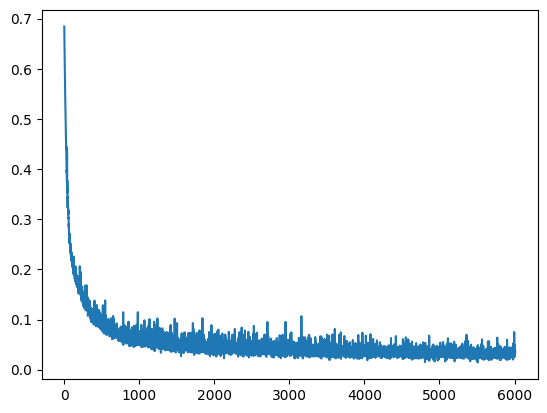

In [14]:
import matplotlib.pyplot as plt

plt.plot(train_record['loss'])

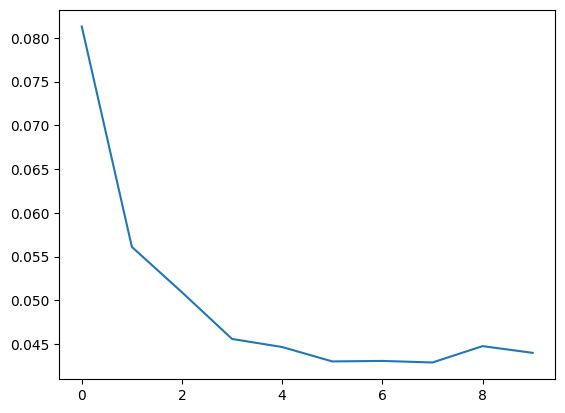

In [17]:
plt.plot([i.cpu() for i in train_record['valid_loss'] ])

# 학습된 UNet 기반 crack segmentation inference 수행

- 총 6개의 image에 대해 segmentation을 수행

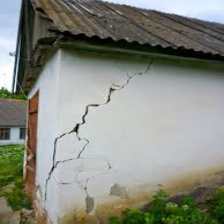

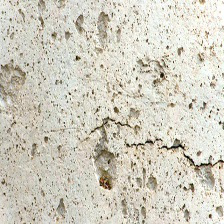

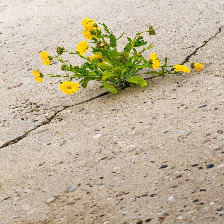

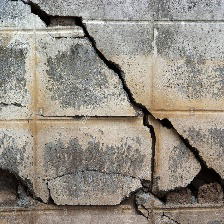

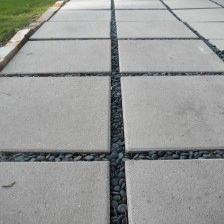

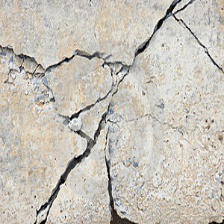

In [21]:
# 이미지 데이터 확인

test_data_path = Path("/content/drive/MyDrive/dl_project/crack_test_data")

test_data_PIL = [Image.open(path) for path in sorted(list(test_data_path.glob("*.*")))]\

for data in test_data_PIL:
  data.show()
  print()

In [44]:
# 각 image를 합쳐 batch 구현, pixel data 값의 범위 확인

pil2tensor = ToTensor()
test_data_batch = torch.stack([pil2tensor(data) for data in test_data_PIL])
print("test data batch shape :", test_data_batch.shape)
print(test_data_batch.max()) # value : 0 ~ 1.0 임을 파악할 수 있다.

test data batch shape : torch.Size([6, 3, 224, 224])
tensor(1.)


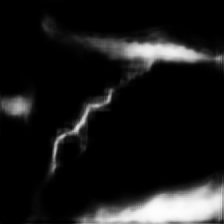

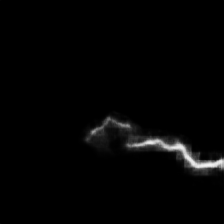

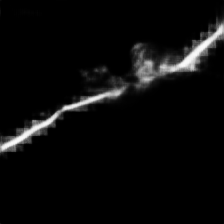

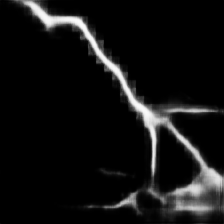

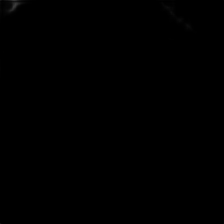

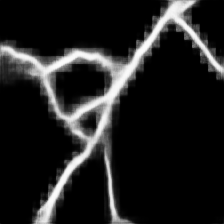

In [31]:
# segmentation 수행 및 시각화

from torchvision.transforms.functional import to_pil_image

model.to('cpu')
with torch.no_grad():
  inference = model(test_data_batch)

for i in range(len(test_data_PIL)):
  to_pil_image(torch.sigmoid(inference[i])).show()
  print()

In [45]:
test_data_batch += torch.sigmoid(torch.concat([inference, inference, inference], dim = 1))

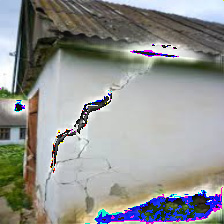

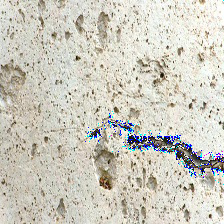

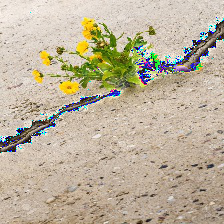

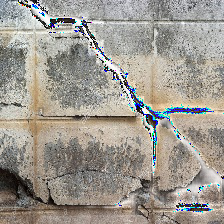

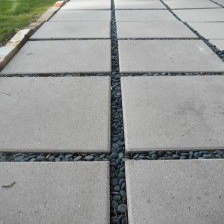

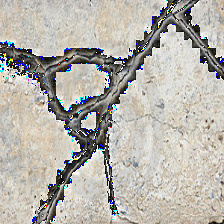

In [46]:
# 원본 image와 통합해 segmentation 시각화

for i in range(len(test_data_PIL)):
  to_pil_image(test_data_batch[i]).show()
  print()